In [1]:
# Analysis
# Import Python Mobules
import os, json, time
import numpy as np
from sys import argv
import tensorflow as tf
import tensorflow.keras as keras

# Reduce warnings
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
buildEnv = True
# Read current devices
devices = tf.config.get_visible_devices()
if buildEnv:    print( 'Devices:', devices )

# If no GPU found, use CPU
if len(devices) == 1:
    strategy = tf.distribute.OneDeviceStrategy('CPU') # Use local GPU

# if buildEnv, probably on hamilton. Use GPU 2
elif buildEnv:
    tf.config.set_visible_devices(devices[0:1]+devices[2:3])
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

# Standard single GPU on backus
else:
    tf.config.set_visible_devices(devices[0:1]+devices[1:2])
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:0') # Use local GPU


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2022-11-15 13:35:14.009611: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 13:35:14.506899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9612 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [3]:
def sliceKey( dictIn ):
    dictOut =  dictIn
    for k in dictOut:
        if type( dictOut[k] ) == type( 'string' ):
            if 'slice' in dictOut[k]:
                #print( k, dictOut[k] )
                tmp = dictOut[k].split('(')[1].split(')')[0].split(',')
                s = int( tmp[0] )
                e = int( tmp[1] )
                dictOut[k] = slice( s, e )
                print( dictOut[k] )
    
    return dictOut 


In [4]:
# Prepare data
with open( 'data/data-key.json' ) as keyFile:
    key = json.load( keyFile )
    
key = sliceKey( key )

mNames = os.listdir( 'models/score-all/' )
mNames.sort()
for m in mNames:
    print( m )

slice(1, 16, None)
slice(16, 23, None)
.ipynb_checkpoints
11-14-overnight-1668479838-100.h5
11-14-overnight-1668482947-200.h5
15-10-1668528879-20.h5
15-10-1668529577-40.h5
15-10-1668530274-60.h5
15-10-1668530972-80.h5
15-10-1668531553-100.h5
15-10-1668532203-120.h5
15-10-1668532835-140.h5
15-10-1668533482-160.h5
15-10-1668534113-180.h5
15-10-1668534777-200.h5
debug-test-1668527992-2.h5
debug-test-1668528082-4.h5


In [5]:
with strategy.scope():
    modelLoc = 'models/score-all/15-10-1668534777-200.h5'
    model = keras.models.load_model(modelLoc) 
    model.summary(expand_nested=False)
    print("done")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 16)                524304    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,089,121
Trainable params: 24,043,681
Non-trainable params: 45,440
_________________________________________________________________
done


In [7]:

    # Load testing data
    testScore = np.load('data/test-data.npy' )[:,key['score']]
    testImg   = np.load('data/test-img.npy' )

    print( 'testImg: ', testImg.shape )


    # Load training data
    trainScore = np.load('data/train-data.npy' )[:,key['score']]
    trainImg   = np.load('data/train-img.npy' )
    print( 'trainImg:  ', trainImg.shape )

testImg:  (1412, 128, 128, 3)
trainImg:   (5648, 128, 128, 3)


In [8]:
pTestScores = model.predict( testImg )
print( 'pTest: ', pTestScores.shape )

pTrainScores = model.predict( trainImg )

2022-11-15 13:35:46.080531: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_7209"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT

pTest:  (1412, 1)


2022-11-15 13:35:51.666922: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8502"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:25"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

pTrain:  (5648, 1)


In [9]:

print( 'pTest: ', pTestScores.shape )
print( 'pTrain: ', pTrainScores.shape )

pTest:  (1412, 1)
pTrain:  (5648, 1)


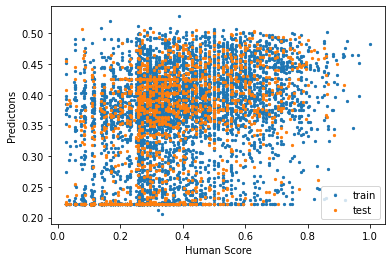

In [10]:
import matplotlib.pyplot as plt
plt.scatter( trainScore, pTrainScores, label='train', s=5 ) 
plt.scatter( testScore, pTestScores, label='test', s=5 )

plt.xlabel('Human Score')
plt.ylabel('Predictons')
plt.legend()
